In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, CosineAnnealingLR
import torch.nn.functional as F

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda
NVIDIA H200
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


# model hyperparameters
## B is set to 3072, the architecture follows:
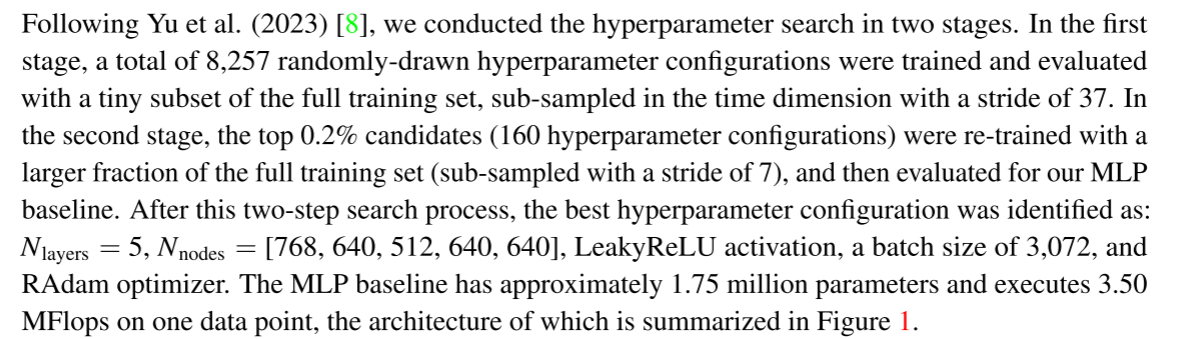

In [2]:
model_name = 'MLP'
LEARNING_RATE = 1e-4
IN_FEATURES = 124
OUT_FEATURES = 128
BATCH_SIZE = 3072
# run for 10 epochs for demostration, the actual epoch is 200
EPOCHS = 10

# load data
## X(input) has shape of [B, 124], y(output) [B, 128]
## The difference among "train", "test" and "scoring" are the number of time steps

In [3]:
# use all 8 years: change path
X_train=np.load('/projects/sds-lab/Shuochen/climsim/train_input.npy')
y_train=np.load('/projects/sds-lab/Shuochen/climsim/train_target.npy')
X_test=np.load('/projects/sds-lab/Shuochen/climsim/val_input.npy')
y_test=np.load('/projects/sds-lab/Shuochen/climsim/val_target.npy')
X_scoring = np.load('/projects/sds-lab/Shuochen/climsim/scoring_input.npy')
y_scoring = np.load('/projects/sds-lab/Shuochen/climsim/scoring_target.npy')

X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)
X_scoring = torch.Tensor(X_scoring)
y_scoring = torch.Tensor(y_scoring)

# create datasets
training_set = TensorDataset(X_train, y_train)
testing_set = TensorDataset(X_test, y_test)
scoring_set = TensorDataset(X_scoring, y_scoring)
# create dataloaders
train_dataloader = DataLoader(training_set, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)
test_dataloader = DataLoader(testing_set,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)
scoring_dataloader = DataLoader(scoring_set,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

print(X_train.shape, X_test.shape, X_scoring.shape)
print(y_train.shape, y_test.shape, y_scoring.shape)

torch.Size([10091520, 124]) torch.Size([1441920, 124]) torch.Size([1681920, 124])
torch.Size([10091520, 128]) torch.Size([1441920, 128]) torch.Size([1681920, 128])


# define model

In [4]:
class MLP(nn.Module):
    def __init__(self, IN_FEATURES, OUT_FEATURES):
        super().__init__()
        self.seq = nn.Sequential(nn.Linear(IN_FEATURES, 768),
                                 nn.LeakyReLU(0.15),
                                 nn.Linear(768, 640),
                                 nn.LeakyReLU(0.15),
                                 nn.Linear(640, 512),
                                 nn.LeakyReLU(0.15),
                                 nn.Linear(512, 640),
                                 nn.LeakyReLU(0.15),
                                 nn.Linear(640, 640),
                                 nn.LeakyReLU(0.15),
                                 nn.Linear(640, 128),
                                 nn.LeakyReLU(0.15))
        self.linear1 = nn.Linear(128, 120)
        self.linear2 = nn.Linear(128, 8)
        self.relu = nn.ReLU()

    def forward(self, x):
        temp = self.seq(x)
        # a = temp[:,:120]
        # b = self.relu(temp[:,120:])
        a = self.linear1(temp)
        b = self.relu(self.linear2(temp))
        return torch.concat((a, b), dim=1)
        
model = MLP(IN_FEATURES, OUT_FEATURES).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.RAdam(model.parameters(),lr=LEARNING_RATE)

print(model)

MLP(
  (seq): Sequential(
    (0): Linear(in_features=124, out_features=768, bias=True)
    (1): LeakyReLU(negative_slope=0.15)
    (2): Linear(in_features=768, out_features=640, bias=True)
    (3): LeakyReLU(negative_slope=0.15)
    (4): Linear(in_features=640, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.15)
    (6): Linear(in_features=512, out_features=640, bias=True)
    (7): LeakyReLU(negative_slope=0.15)
    (8): Linear(in_features=640, out_features=640, bias=True)
    (9): LeakyReLU(negative_slope=0.15)
    (10): Linear(in_features=640, out_features=128, bias=True)
    (11): LeakyReLU(negative_slope=0.15)
  )
  (linear1): Linear(in_features=128, out_features=120, bias=True)
  (linear2): Linear(in_features=128, out_features=8, bias=True)
  (relu): ReLU()
)


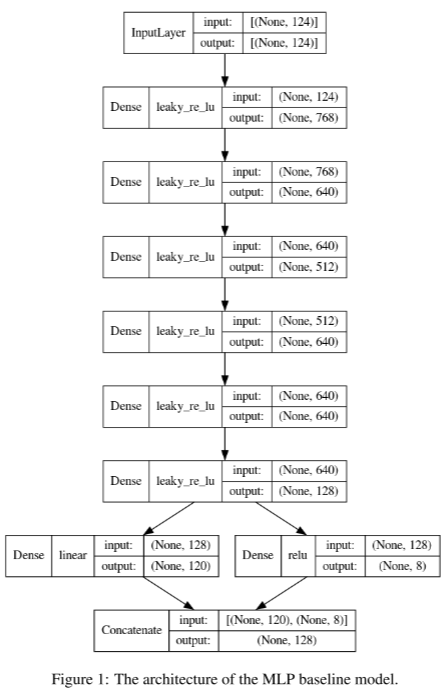

# training

In [5]:
train_loss_list = []
test_loss_list = []

for epoch in range(EPOCHS):
    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        y_pred = model(X.to(device))
        loss = loss_fn(y_pred, y.to(device))
        train_loss += loss # accumulatively add up the loss per epoch 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    train_loss_list.append(train_loss.detach().cpu().numpy())
    
    model.eval()
    with torch.no_grad():
        test_loss = 0
        for X, y in test_dataloader:
            test_pred = model(X.to(device))
            test_loss += loss_fn(test_pred, y.to(device)) # accumulatively add up the loss per epoch
        
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)
        test_loss_list.append(test_loss.detach().cpu().numpy())

    print(f"Epoch: {epoch} | Train loss: {train_loss:.5f} | Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.00765 | Test loss: 0.00529
Epoch: 1 | Train loss: 0.00512 | Test loss: 0.00503
Epoch: 2 | Train loss: 0.00496 | Test loss: 0.00491
Epoch: 3 | Train loss: 0.00480 | Test loss: 0.00476
Epoch: 4 | Train loss: 0.00471 | Test loss: 0.00471
Epoch: 5 | Train loss: 0.00466 | Test loss: 0.00466
Epoch: 6 | Train loss: 0.00461 | Test loss: 0.00460
Epoch: 7 | Train loss: 0.00457 | Test loss: 0.00458
Epoch: 8 | Train loss: 0.00454 | Test loss: 0.00456
Epoch: 9 | Train loss: 0.00451 | Test loss: 0.00452


# test
## To calculate the MSE and R2 for the entire test set, need to combine the minibatches first

In [14]:
test_pred = []
with torch.no_grad():
    for X, y in test_dataloader:
        X = X.to(device)
        y_pred = model(X.to(device))
        test_pred.append(y_pred.cpu())
test_pred = torch.cat(test_pred, dim=0)
print(test_pred.shape)

torch.Size([1441920, 128])


In [17]:
loss = nn.MSELoss()
print(loss(torch.Tensor(test_pred), torch.Tensor(y_test)))

def r2_score(y_pred:torch.Tensor, y_true:torch.Tensor) -> float:

    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    
    r2 = 1 - ss_res / ss_tot
    return r2

print(r2_score(torch.Tensor(test_pred), torch.Tensor(y_test)))

tensor(0.0045)
tensor(0.8922)
